# Data Preparation

## 1.1. Environment Setup

In [132]:
from census import Census
import pandas as pd
import os
import cenpy
import altair as alt
import geopandas as gpd
import hvplot.pandas
import numpy as np
import seaborn as sns
import pygris
from matplotlib import pyplot as plt

In [133]:
#| echo: false

%matplotlib inline

# Set your Census API key
CENSUS_API_KEY = "*****************"
c = Census(CENSUS_API_KEY)

## 1.2. Load Spatial Data

::: {.callout-note}
A GeoJSON holding for Philadelphia census tract boundary is available in the /data directory.
:::

In [134]:
tract = gpd.read_file("./data/Census_Tracts_2010.geojson")
tract.head()

OBJECTID STATEFP10 COUNTYFP10 TRACTCE10      GEOID10 NAME10  \
0         1        42        101    009400  42101009400     94   
1         2        42        101    009500  42101009500     95   
2         3        42        101    009600  42101009600     96   
3         4        42        101    013800  42101013800    138   
4         5        42        101    013900  42101013900    139   

         NAMELSAD10 MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10  \
0   Census Tract 94   G5020          S   366717         0  +39.9632709   
1   Census Tract 95   G5020          S   319070         0  +39.9658709   
2   Census Tract 96   G5020          S   405273         0  +39.9655396   
3  Census Tract 138   G5020          S   341256         0  +39.9764504   
4  Census Tract 139   G5020          S   562934         0  +39.9750563   

     INTPTLON10 LOGRECNO                                           geometry  
0  -075.2322437    10429  POLYGON ((-75.22927 39.96054, -75.22865 39.960...  
1  -075.2379140    10430  POLYGON ((-75.23536 39.96852, -75.23545 39.969...  
2  -075.2435075    10431  POLYGON ((-75.24343 39.96230, -75.24339 39.962...  
3  -075.1771771    10468  POLYGON ((-75.17341 39.97779, -75.17386 39.977...  
4  -075.1711846    10469  POLYGON ((-75.17313 39.97776, -75.17321 39.977...

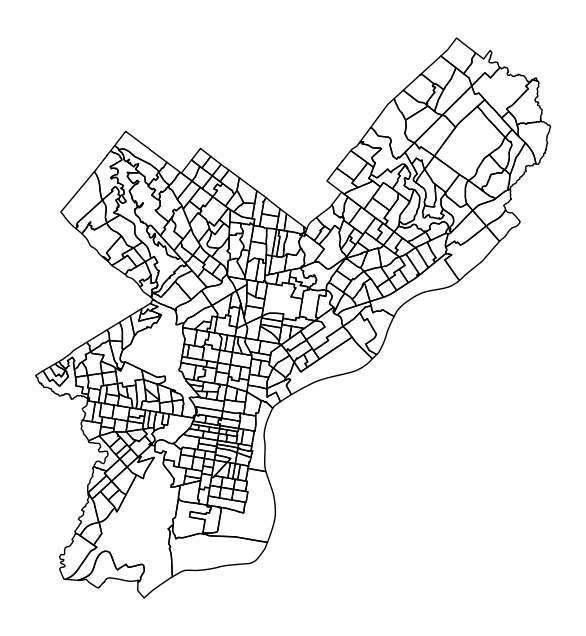

In [135]:
#| label: fig-figure1
#| fig-cap: "Census tract of Philadelphia"
#| code-fold: true
#| code-summary: "Code for Visualization"

fig, ax = plt.subplots(figsize=(8, 8))

ax =tract.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="black")
ax.set_axis_off()
ax.set_aspect("equal")

## 1.3. Child Blood Lead Level

In [136]:
lead = gpd.read_file("./data/child_blood_lead_levels_by_ct.geojson")

tract = tract.to_crs(epsg=3857)  # Ensure 'tract' is in projected CRS
lead = lead.to_crs(epsg=3857) 

# Spatial join between ceansus tracts and lead data
joined = gpd.sjoin(tract, lead, how="left", predicate="intersects")

# Replace 'NAMELSAD10' and 'perc_5plus' with the appropriate column names
lead_aggregated = joined.groupby(["NAMELSAD10", "GEOID10"]).agg({
    "perc_5plus": "mean",  # Example: Average value from lead
    "geometry": "first"     # Keep one geometry per tract
}).reset_index()

display(lead_aggregated.head())

lead_aggregated = gpd.GeoDataFrame(lead_aggregated, geometry="geometry", crs="EPSG:3857")

NAMELSAD10      GEOID10  perc_5plus  \
0      Census Tract 1  42101000100    0.000000   
1  Census Tract 10.01  42101001001    0.000000   
2  Census Tract 10.02  42101001002    0.000000   
3    Census Tract 100  42101010000    6.180000   
4    Census Tract 101  42101010100    5.333333   

                                            geometry  
0  POLYGON ((-8364710.415 4858926.985, -8364708.8...  
1  POLYGON ((-8366008.694 4858067.328, -8366013.2...  
2  POLYGON ((-8365697.832 4857770.055, -8365707.4...  
3  POLYGON ((-8376459.164 4861101.785, -8376441.0...  
4  POLYGON ((-8375582.343 4861569.516, -8375572.4...

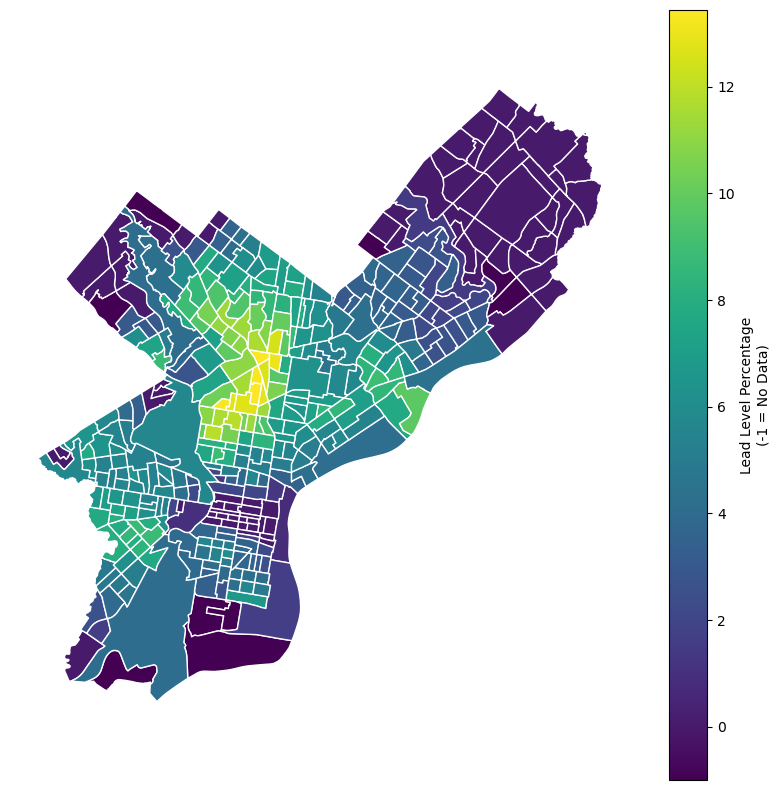

In [137]:
#| label: fig-figure2
#| fig-cap: "Average Lead Level Percentage by Census Tract"
#| code-fold: true
#| code-summary: "Code for Visualization"

# Replace NaN values with -1 for visualization
lead_aggregated["perc_5plus"] = lead_aggregated["perc_5plus"].fillna(-1)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
lead_aggregated.plot(
    ax=ax,
    column="perc_5plus",  # Use the column with lead level data
    cmap="viridis",       # Colormap for numerical data
    edgecolor="white",    # Boundary color
    legend=True,          # Add legend
    legend_kwds={
        "label": "Lead Level Percentage\n(-1 = No Data)",
        "orientation": "vertical",
    },
)

# Format the plot
# ax.set_title("Average Lead Level Percentage by Census Tract", fontsize=16)
ax.set_axis_off()

# Show the plot
plt.show()

## 1.4. Cancer and Asthma

In [138]:
cancer_asthma= gpd.read_file("data/philadelphia_gdf.geojson")
cancer_asthma.head()

countyname    tractfips casthma_crudeprev cancer_crudeprev  \
0  Philadelphia  42101002500              11.3              5.2   
1  Philadelphia  42101003702              12.8              4.8   
2  Philadelphia  42101031401              11.6              4.1   
3  Philadelphia  42101031502              11.7              6.2   
4  Philadelphia  42101033200              10.4              6.7   

  totalpopulation                          geometry  
0            3769  POINT (-8365639.619 4856398.197)  
1            3707  POINT (-8369269.171 4854982.142)  
2            6664  POINT (-8356372.430 4872587.322)  
3            4018  POINT (-8355069.752 4871650.082)  
4            2741  POINT (-8353959.244 4872306.058)

In [139]:
cancer_asthma = cancer_asthma.to_crs(epsg=3857)

selected_columns = ["countyname", "tractfips","geometry", "casthma_crudeprev", "cancer_crudeprev", "totalpopulation"]
filtered_gdf = cancer_asthma[selected_columns]

# Filter for rows where CountyName is Philadelphia
philadelphia_gdf = filtered_gdf[filtered_gdf["countyname"].str.contains("Philadelphia", case=False, na=False)]

cancer_asthma_aggregated = gpd.sjoin(lead_aggregated, philadelphia_gdf, how="left", predicate="intersects")

In [140]:
# Get the number of rows
num_rows = cancer_asthma_aggregated.shape[0]

cancer_asthma_aggregated["casthma_crudeprev"] = pd.to_numeric(cancer_asthma_aggregated["casthma_crudeprev"], errors="coerce")
cancer_asthma_aggregated["cancer_crudeprev"] = pd.to_numeric(cancer_asthma_aggregated["cancer_crudeprev"], errors="coerce")

# Get the range of 'casthma_crudeprev'
asthma_min = cancer_asthma_aggregated["casthma_crudeprev"].min()
asthma_max = cancer_asthma_aggregated["casthma_crudeprev"].max()

# Get the range of 'cancer_crudeprev'
cancer_min = cancer_asthma_aggregated["cancer_crudeprev"].min()
cancer_max = cancer_asthma_aggregated["cancer_crudeprev"].max()

cancer_asthma_aggregated = cancer_asthma_aggregated.groupby(["NAMELSAD10", "GEOID10"]).agg({
    "perc_5plus": "mean",        # Average percentage of lead exposure
    "casthma_crudeprev": "mean", # Average asthma crude prevalence
    "cancer_crudeprev": "mean",  # Average cancer crude prevalence
    "geometry": "first"          # Retain the first geometry
}).reset_index()

cancer_asthma_aggregated.head()

NAMELSAD10      GEOID10  perc_5plus  casthma_crudeprev  \
0      Census Tract 1  42101000100    0.000000                9.2   
1  Census Tract 10.01  42101001001    0.000000                8.9   
2  Census Tract 10.02  42101001002    0.000000                9.0   
3    Census Tract 100  42101010000    6.180000               13.5   
4    Census Tract 101  42101010100    5.333333               13.6   

   cancer_crudeprev                                           geometry  
0               3.4  POLYGON ((-8364710.415 4858926.985, -8364708.8...  
1               8.4  POLYGON ((-8366008.694 4858067.328, -8366013.2...  
2               7.2  POLYGON ((-8365697.832 4857770.055, -8365707.4...  
3               4.6  POLYGON ((-8376459.164 4861101.785, -8376441.0...  
4               5.5  POLYGON ((-8375582.343 4861569.516, -8375572.4...

In [151]:
cancer_asthma_aggregated = gpd.GeoDataFrame(cancer_asthma_aggregated, geometry="geometry", crs="EPSG:3857")

# Fill NaN values with a placeholder (-1) for "No Data"
cancer_asthma_aggregated["cancer_crudeprev_filled"] = cancer_asthma_aggregated["cancer_crudeprev"].fillna(-1)
cancer_asthma_aggregated["casthma_crudeprev"] = cancer_asthma_aggregated["casthma_crudeprev"].fillna(-1)

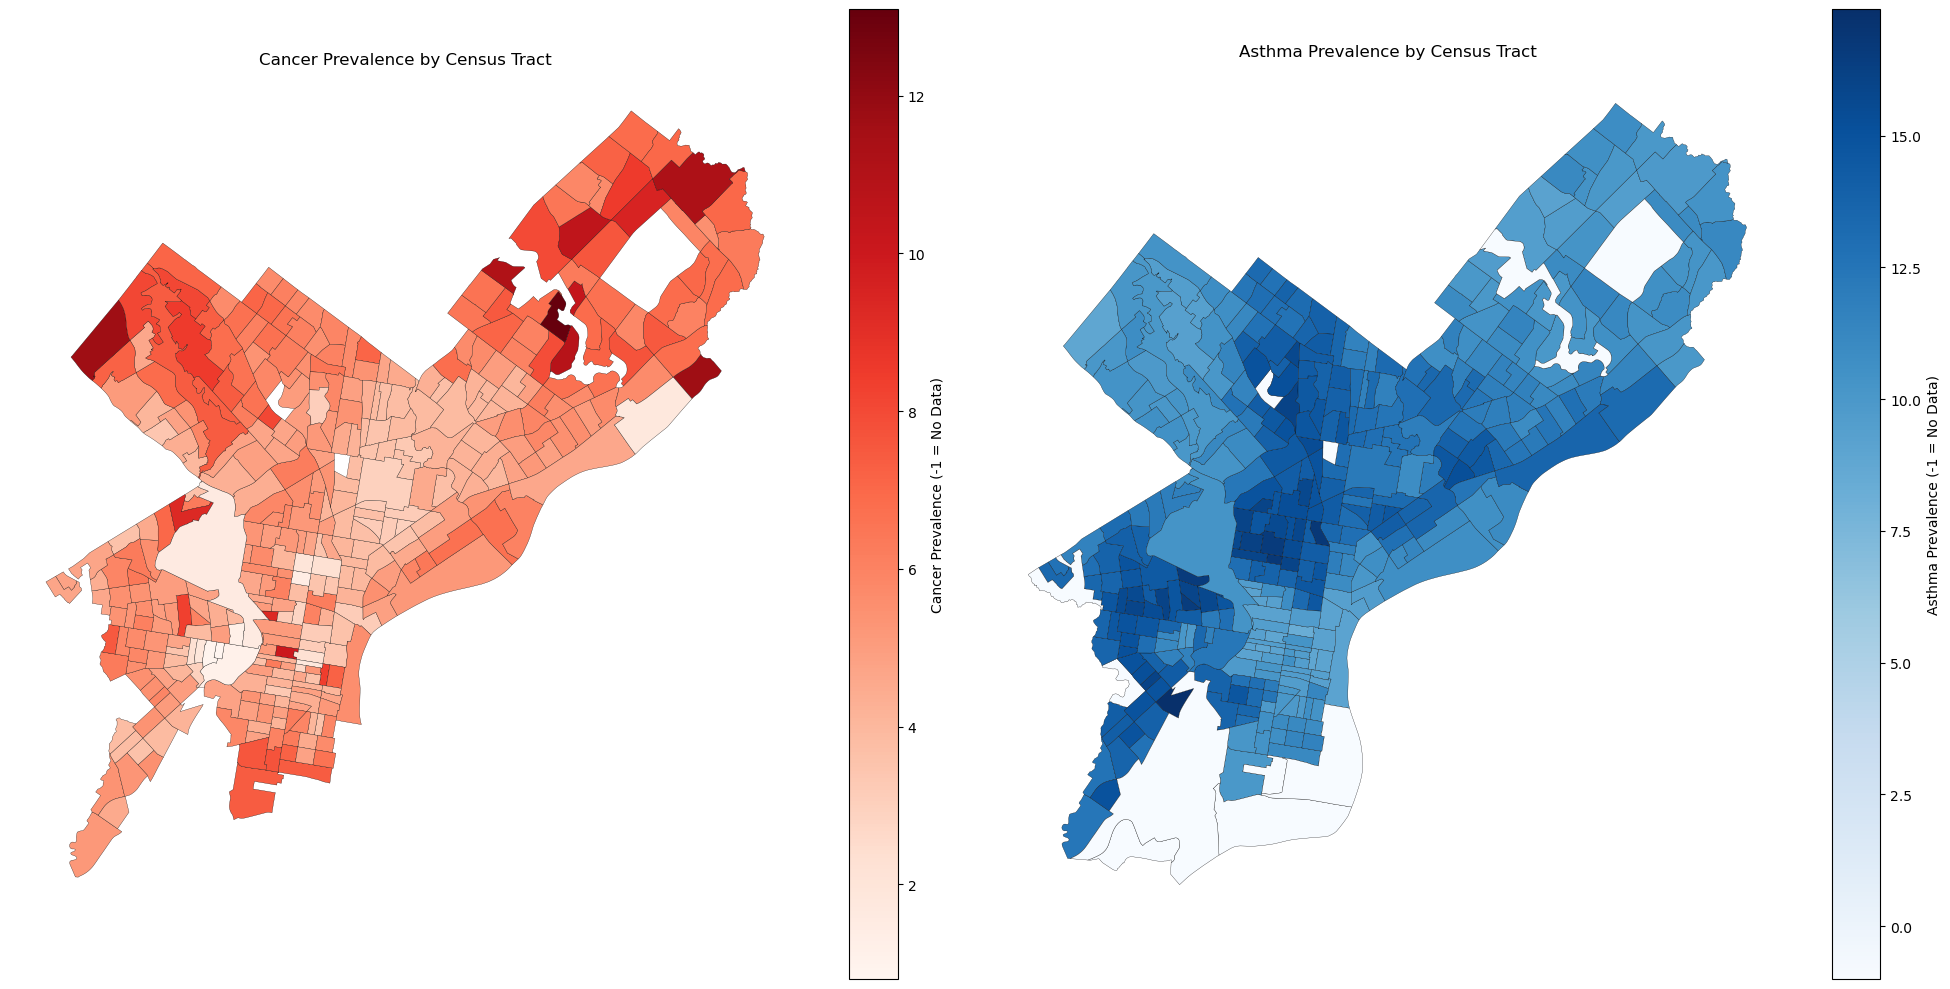

In [185]:
#| label: fig-figure3
#| fig-cap: "Cancer and Asthma Prevalence by Census Tract"
#| code-fold: true
#| code-summary: "Code for Visualization"

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

cancer_asthma_aggregated.plot(
    ax=axes[0],
    column="cancer_crudeprev",
    cmap="Reds",
    edgecolor="black",
    linewidth=0.2,
    legend=True,
    legend_kwds={"label": "Cancer Prevalence (-1 = No Data)"},
)
axes[0].set_title("Cancer Prevalence by Census Tract")
axes[0].set_axis_off()

cancer_asthma_aggregated.plot(
    ax=axes[1],
    column="casthma_crudeprev",
    cmap="Blues",
    edgecolor="black",
    linewidth=0.2,
    legend=True,
    legend_kwds={"label": "Asthma Prevalence (-1 = No Data)"},
)
axes[1].set_title("Asthma Prevalence by Census Tract")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

## 1.5. Heat Vulerability

In [186]:
heatindex = gpd.read_file("data/heat_vulnerability_ct.geojson")
heatindex.head()

geoid10  name10  n_veryhigh  year  hsi_score  hei_score  hvi_score  \
0  42101002100      21           0  2023   0.502262  -1.481429   0.639224   
1  42101002200      22           0  2023  -3.183298  -1.658469  -1.769318   
2  42101002300      23           0  2023  -6.884403  -1.193579  -4.362779   
3  42101002400      24           0  2023  -7.107618  -1.382308  -4.462616   
4  42101034803  348.03           0  2023  -7.830042  -0.358619  -5.684468   

   objectid   Shape__Area  Shape__Length  \
0         1  4.044948e+05    2580.858471   
1         2  3.894601e+05    2518.894793   
2         3  3.616223e+05    2771.142380   
3         4  9.117703e+05    4810.554362   
4         5  2.186876e+06    6444.130598   

                                            geometry  
0  POLYGON ((-75.17370 39.93624, -75.17378 39.935...  
1  POLYGON ((-75.17370 39.93624, -75.17369 39.936...  
2  POLYGON ((-75.16702 39.93675, -75.16696 39.936...  
3  POLYGON ((-75.16629 39.94004, -75.16623 39.940...  
4  POLYGON ((-75.00888 40.05866, -75.00915 40.059...

In [188]:
heatindex = heatindex.to_crs(epsg=3857)

# Perform the spatial join
joined_with_heatindex = gpd.sjoin(cancer_asthma_aggregated, heatindex, how="left", predicate="intersects")

aggregated_heat = joined_with_heatindex.groupby(["NAMELSAD10", "GEOID10"]).agg({
    "perc_5plus": "mean",        # Average percentage of lead exposure
    "casthma_crudeprev": "mean", # Average asthma crude prevalence
    "cancer_crudeprev": "mean",  # Average cancer crude prevalence
    "hvi_score": "mean",   # Average of heat index data
    "geometry": "first"          # Retain the first geometry
}).reset_index()

aggregated_heat = gpd.GeoDataFrame(aggregated_heat, geometry="geometry", crs="EPSG:3857")

# Handle missing data
aggregated_heat["hvi_score"] = aggregated_heat["hvi_score"].fillna(-1)  # Replace NaN with -1 for "No Data"

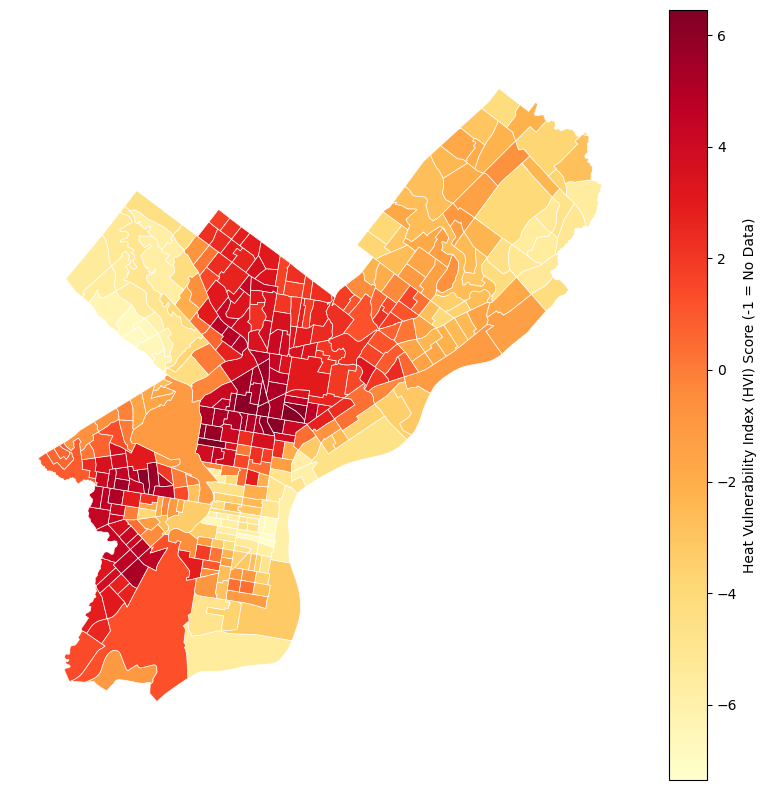

In [189]:
#| label: fig-figure4
#| fig-cap: "Heat Vulnerability Index (HVI) Score by Census Tract"
#| code-fold : true
#| code-summary: "Code for Visualization"

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
aggregated_heat.plot(
    ax=ax,
    column="hvi_score",  # Replace with the HVI column name
    cmap="YlOrRd",       # Colormap for heat index visualization
    edgecolor="white",  
    linewidth = 0.5,
    legend=True,         # Add a legend
    legend_kwds={
        "label": "Heat Vulnerability Index (HVI) Score (-1 = No Data)",
        "orientation": "vertical",
    },
)

# Remove axis
ax.set_axis_off()

# Show the plot
plt.show()

## 1.6. Tree Canpoy

In [101]:
tree_canopy = gpd.read_file("data/ppr_tree_canopy_outlines_2015.geojson")
# Ensure CRS alignment
tree_canopy = tree_canopy.to_crs("EPSG:3857")
aggregated_heat = aggregated_heat.to_crs("EPSG:3857")

# Perform spatial intersection
intersected = gpd.overlay(tree_canopy, aggregated_heat, how="intersection")

# Calculate tree canopy area (in square meters)
intersected["canopy_area"] = intersected.geometry.area

aggregated_with_canopy = intersected.groupby(["NAMELSAD10", "GEOID10"]).agg({
    "perc_5plus": "mean",        # Average percentage of lead exposure
    "casthma_crudeprev": "mean", # Average asthma crude prevalence
    "cancer_crudeprev": "mean",  # Average cancer crude prevalence
    "hvi_score": "mean",   # Average of heat index data
    "canopy_area": "sum",         # Total canopy area within each tract
    "geometry": "first"          # Retain the first geometry
}).reset_index()

# Merge the aggregated results back with the original GeoDataFrame
aggregated_with_canopy_full = aggregated_heat.merge(
    aggregated_with_canopy, 
    on="NAMELSAD10", 
    how="left", 
    suffixes=("", "_aggregated")
)

# Rename columns
aggregated_with_canopy_full = aggregated_with_canopy_full.rename(
    columns={
        "GEOID10": "GEOID" # Rename GEOID to match Census
    }
)

# Fill missing values for 'canopy_area' and 'canopy_percent' with 0
aggregated_with_canopy_full["canopy_area"] = aggregated_with_canopy_full["canopy_area"].fillna(0)
aggregated_with_canopy_full["canopy_percent"] = aggregated_with_canopy_full["canopy_area"] / aggregated_with_canopy_full.geometry.area * 100

aggregated_with_canopy_full.head()

NAMELSAD10        GEOID  perc_5plus  casthma_crudeprev  \
0      Census Tract 1  42101000100    0.000000                9.2   
1  Census Tract 10.01  42101001001    0.000000                8.9   
2  Census Tract 10.02  42101001002    0.000000                9.0   
3    Census Tract 100  42101010000    6.180000               13.5   
4    Census Tract 101  42101010100    5.333333               13.6   

   cancer_crudeprev  hvi_score  \
0               3.4  -4.917169   
1               8.4  -6.734700   
2               7.2  -6.821269   
3               4.6   2.479992   
4               5.5   3.499149   

                                            geometry GEOID10_aggregated  \
0  POLYGON ((-8364710.415 4858926.985, -8364708.8...        42101000100   
1  POLYGON ((-8366008.694 4858067.328, -8366013.2...        42101001001   
2  POLYGON ((-8365697.832 4857770.055, -8365707.4...        42101001002   
3  POLYGON ((-8376459.164 4861101.785, -8376441.0...        42101010000   
4  POLYGON ((-8375582.343 4861569.516, -8375572.4...        42101010100   

   perc_5plus_aggregated  casthma_crudeprev_aggregated  \
0               0.000000                           9.2   
1               0.000000                           8.9   
2               0.000000                           9.0   
3               6.180000                          13.5   
4               5.333333                          13.6   

   cancer_crudeprev_aggregated  hvi_score_aggregated   canopy_area  \
0                          3.4             -4.917169  15295.431073   
1                          8.4             -6.734700  18685.893835   
2                          7.2             -6.821269  35866.481410   
3                          4.6              2.479992  18194.466411   
4                          5.5              3.499149  30726.883686   

                                 geometry_aggregated  canopy_percent  
0  POLYGON ((-8365601.290 4859085.382, -8365600.7...        1.272227  
1  POLYGON ((-8365867.678 4857764.287, -8365867.3...        4.781632  
2  POLYGON ((-8365243.510 4858160.829, -8365243.0...        4.464418  
3  POLYGON ((-8377098.367 4862164.604, -8377097.8...        2.147186  
4  POLYGON ((-8376335.161 4861584.880, -8376334.7...        2.996808

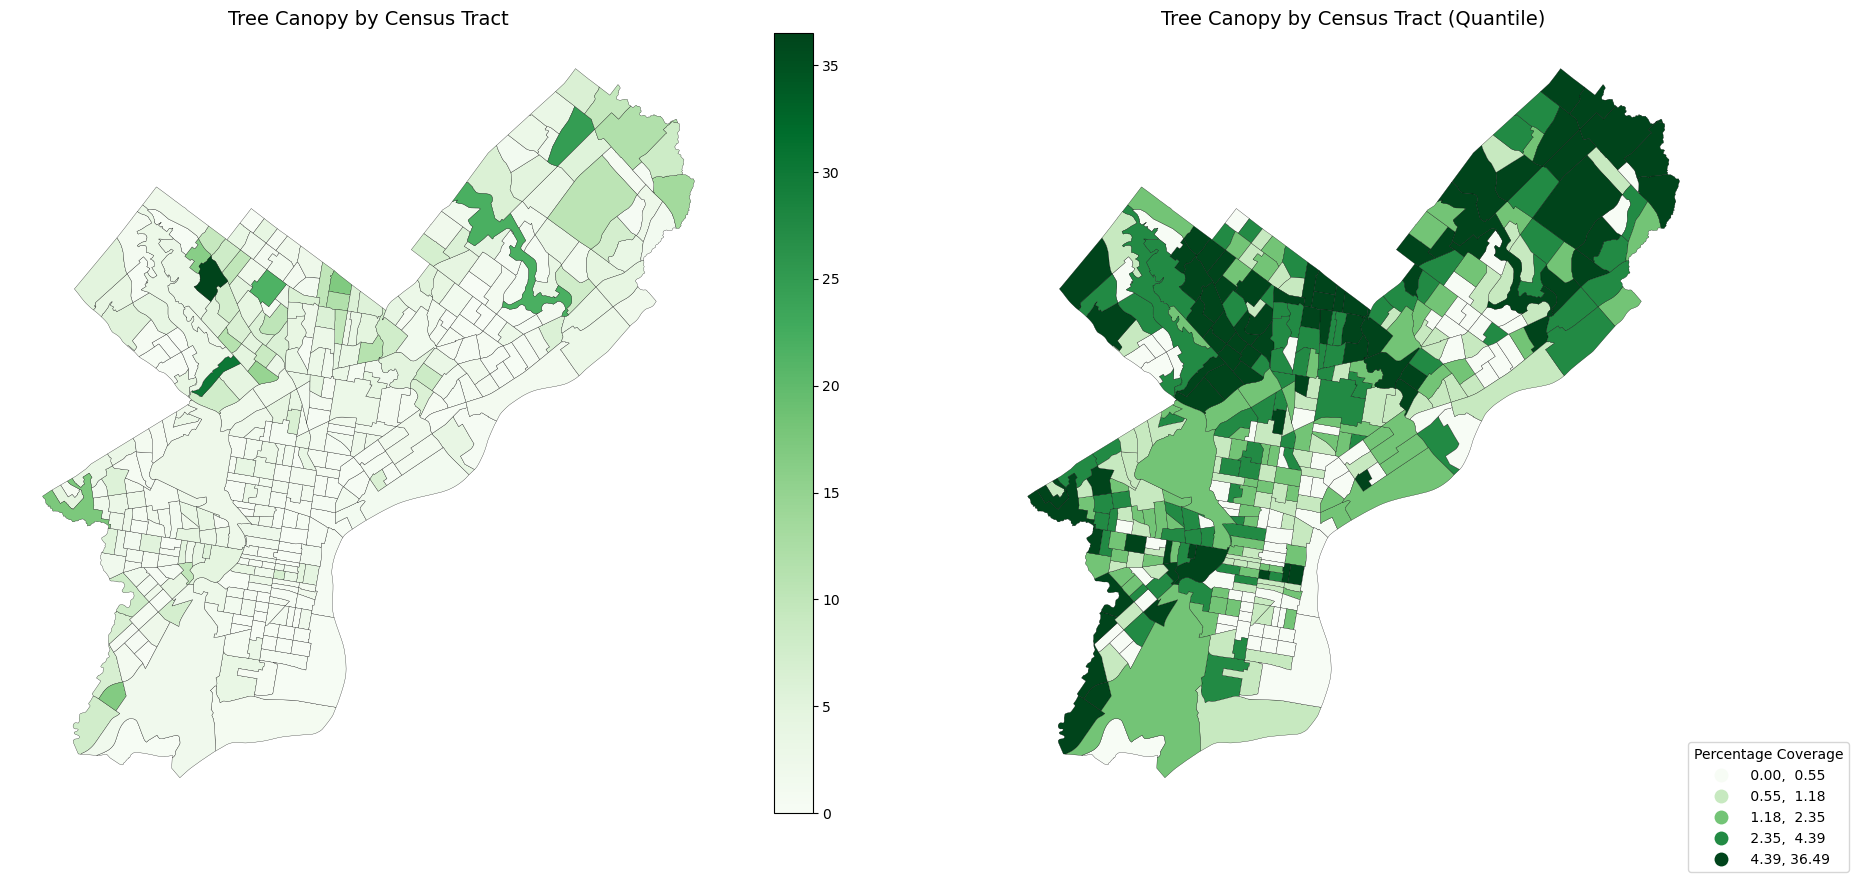

In [193]:
#| label: fig-figure5
#| fig-cap: "Tree Canopy Converage"
#| code-fold : true
#| code-summary: "Code for Visualization"

# Plot Tree Canopy (unedited and quantile)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Tree Canopy
aggregated_with_canopy_full.plot(
    ax=axes[0],
    column="canopy_percent",
    cmap="Greens",
    edgecolor="black",
    linewidth=0.2,
    legend=True,
)
axes[0].set_title("Tree Canopy by Census Tract", fontsize=14)
axes[0].set_axis_off()

# Plot 2: Tree Canopy (Quantile)
aggregated_with_canopy_full.plot(
    ax=axes[1],
    column="canopy_percent",
    cmap="Greens",
    scheme="quantiles",
    k=5,
    edgecolor="black",
    linewidth=0.2,
    legend=True,
)
axes[1].set_title("Tree Canopy by Census Tract (Quantile)", fontsize=14)
axes[1].set_axis_off()

# Customize legend for Median Household Income
income_legend = axes[1].get_legend()
income_legend.set_bbox_to_anchor((1.2, 0.1))  # Adjust position to bottom-right
income_legend.set_title("Percentage Coverage")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

## 1.7. Census Data

In [194]:
available = cenpy.explorer.available()

# Return a dataframe for 5 year ACS
# Axis=0 means to filter the index labels!
acs = available.filter(regex="^ACSDT5Y", axis=0)

# Choosing only 2019 ACS 5-Year
## 2019 chosen over 2021 because of the number of census tracts
acs = cenpy.remote.APIConnection("ACSDT5Y2019")

For the purpose of this project, we are interested in finding the following:

- Average Median Income

- Percentage Non-White Population

- Population with High School Dipolma or Higher (Age 25+)

- Percent Dependent Population (Age 0-15 and 65 and older)


In [106]:
# Variables from Census
variables = [
    "NAME",
    "B03002_001E",  # Total population
    "B03002_003E",  # Not Hispanic, White
    "B19013_001E",  # Median household income
    "B15003_017E",  # High School diploma 
    "B15003_018E",  # GED or alternative
    "B15003_019E",  # Some college
    "B15003_020E",  # Some college, more than 1 year
    "B15003_021E",  # Associate's Degree
    "B15003_022E",  # Bachelor's degree
    "B15003_023E",  # Master's degree
    "B15003_024E",  # Professional School
    "B15003_025E",  # Doctorate degree
    "B01001_003E",  # Male Population under 5
    "B01001_004E",  # Male Population 5-9
    "B01001_005E",  # Male Population 10-14
    "B01001_020E",  # Male Population 65-66
    "B01001_021E",  # Male Population 67-69
    "B01001_022E",  # Male Population 70-74
    "B01001_023E",  # Male Population 75-79
    "B01001_024E",  # Male Population 80-84
    "B01001_025E",  # Male Population 85 and older
    "B01001_027E",  # Female Population under 5
    "B01001_028E",  # Female Population 5-9
    "B01001_029E",  # Female Population 10-14
    "B01001_044E",  # Female Population 65-66
    "B01001_045E",  # Female Population 67-69
    "B01001_046E",  # Female Population 70-74
    "B01001_047E",  # Female Population 75-79
    "B01001_048E",  # Female Population 80-84
    "B01001_049E"   # Female Population 85 and older
]

In [107]:
# Define codes for Philly
philly_county_code = "101"
pa_state_code = "42"

# Adjust the geo_unit to query census tracts
philly_census_data = acs.query(
    cols=variables,
    geo_unit="tract:*", 
    geo_filter={"state": pa_state_code, "county": philly_county_code}
)

In [108]:
# Check the data types for each column
# print(philly_census_data.dtypes)

# Convert the data types to numeric 
numeric_columns = [
    "B03002_001E", "B03002_003E", "B19013_001E", 
    "B15003_017E", "B15003_018E", "B15003_019E", 
    "B15003_020E", "B15003_021E", "B15003_022E",  
    "B15003_023E", "B15003_024E", "B15003_025E",  
    "B01001_003E", "B01001_004E", "B01001_005E", 
    "B01001_020E", "B01001_021E", "B01001_022E", 
    "B01001_023E", "B01001_024E", "B01001_025E", 
    "B01001_027E", "B01001_028E", "B01001_029E", 
    "B01001_044E", "B01001_045E", "B01001_046E", 
    "B01001_047E", "B01001_048E", "B01001_049E" 
]

philly_census_data[numeric_columns] = philly_census_data[numeric_columns].apply(pd.to_numeric, errors="coerce")

# Handle missing values 
philly_census_data[numeric_columns] = philly_census_data[numeric_columns].fillna(0)

In [109]:
# Combining Columns to aggregate population data
philly_census_data["Pop_15_and_Younger"] = (
    philly_census_data["B01001_003E"] +  # Male under 5
    philly_census_data["B01001_004E"] +  # Male 5-9
    philly_census_data["B01001_005E"] +  # Male 10-14
    philly_census_data["B01001_027E"] +  # Female under 5
    philly_census_data["B01001_028E"] +  # Female 5-9
    philly_census_data["B01001_029E"]    # Female 10-14
) 


philly_census_data["Pop_65_and_Older"] = (
    philly_census_data["B01001_020E"] +  # Male 65-66
    philly_census_data["B01001_021E"] +  # Male 67-69
    philly_census_data["B01001_022E"] +  # Male 70-74
    philly_census_data["B01001_023E"] +  # Male 75-79
    philly_census_data["B01001_024E"] +  # Male 80-84
    philly_census_data["B01001_025E"] +  # Male 85 and older
    philly_census_data["B01001_044E"] +  # Female 65-66
    philly_census_data["B01001_045E"] +  # Female 67-69
    philly_census_data["B01001_046E"] +  # Female 70-74
    philly_census_data["B01001_047E"] +  # Female 75-79
    philly_census_data["B01001_048E"] +  # Female 80-84
    philly_census_data["B01001_049E"]    # Female 85 and older
)

# Creating Dependent Population Column
philly_census_data["Dependent_Pop"] = (
    philly_census_data["Pop_15_and_Younger"] + 
    philly_census_data["Pop_65_and_Older"]
)

# Creating Percentage dependent population column
philly_census_data["Perc_Dependent_Pop"] = (
    (philly_census_data["Dependent_Pop"] / philly_census_data["B03002_001E"]) * 100
).round(2)


In [110]:
# Combining Columns to aggregate education data
# Education attainment that is at least high school or more
philly_census_data["Edu_HS_Higher"] = (
    philly_census_data["B15003_017E"] +  # High School diploma 
    philly_census_data["B15003_018E"] +  # GED or alternative
    philly_census_data["B15003_019E"] +  # Some college
    philly_census_data["B15003_020E"] +  # Some college, more than 1 year
    philly_census_data["B15003_021E"] +  # Associate's Degree
    philly_census_data["B15003_022E"] +  # Bachelor's degree
    philly_census_data["B15003_023E"] +  # Master's degree
    philly_census_data["B15003_024E"] +  # Professional School
    philly_census_data["B15003_025E"]    # Doctorate degree
) 

# Creating Percentage HS attainment or higher column
philly_census_data["Perc_Edu_HS_Higher"] = (
    (philly_census_data["Edu_HS_Higher"] / philly_census_data["B03002_001E"]) * 100
).round(2)

In [111]:
# Creating Non-White Population Column
philly_census_data["Non_White"] = (
    philly_census_data["B03002_001E"] - philly_census_data["B03002_003E"]
)

# Creating Percentage Non-White Population column
philly_census_data["Perc_Non_White"] = (
    (philly_census_data["Non_White"] / philly_census_data["B03002_001E"]) * 100
).round(2)

In [112]:
# Rename columns
philly_census_data = philly_census_data.rename(
    columns={
        "B03002_001E": "Total_Pop", # Total Population
        "B03002_003E": "White_Only",  # Not Hispanic, White
        "B19013_001E": "Median_Household_Income"
    }
)


# Drop columns that are redundant 
philly_census_data = philly_census_data.drop(columns = [
    "B15003_017E", "B15003_018E", "B15003_019E", 
    "B15003_020E", "B15003_021E", "B15003_022E",  
    "B15003_023E", "B15003_024E", "B15003_025E",  
    "B01001_003E", "B01001_004E", "B01001_005E", 
    "B01001_020E", "B01001_021E", "B01001_022E", 
    "B01001_023E", "B01001_024E", "B01001_025E", 
    "B01001_027E", "B01001_028E", "B01001_029E", 
    "B01001_044E", "B01001_045E", "B01001_046E", 
    "B01001_047E", "B01001_048E", "B01001_049E"]) 

In [113]:
# Fetch the census tracts for Philadelphia 
philly_census_tracts = pygris.tracts(
    state=pa_state_code, 
    county=philly_county_code, 
    year=2019
)

In [114]:
# Merge demographic data with geometries 
census_data = philly_census_tracts.merge(
    philly_census_data,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE"], 
    right_on=["state", "county", "tract"],
)

In [115]:
census_data.explore(column="Total_Pop", tiles="CartoDB positron")

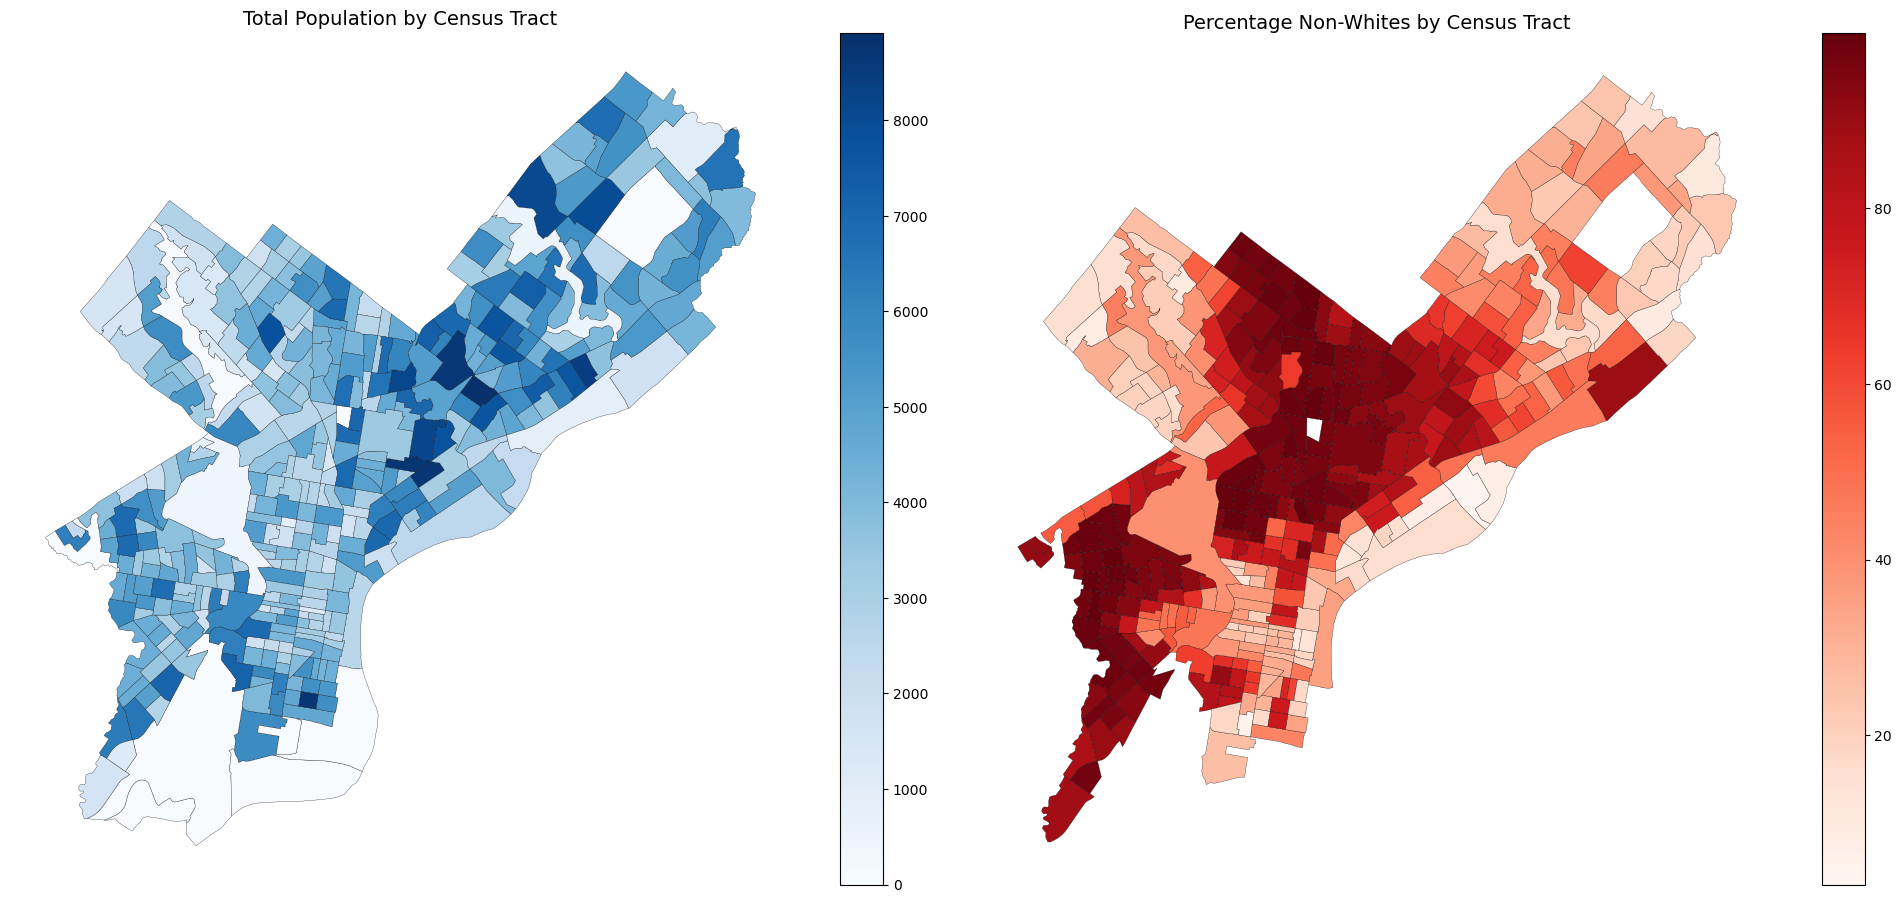

In [195]:
#| label: fig-figure6
#| fig-cap: "Demographic and Population Distribution (2019)"
#| code-fold : true
#| code-summary: "Code for Visualization"

# Plot Population and Non-white Population
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Total Population
census_data.plot(
    ax=axes[0],
    column="Total_Pop",
    cmap="Blues",
    edgecolor="black",
    linewidth=0.2,
    legend=True,
)
axes[0].set_title("Total Population by Census Tract", fontsize = 14)
axes[0].set_axis_off()

# Plot 2: Percentage Non-White
census_data.plot(
    ax=axes[1],
    column="Perc_Non_White",
    cmap="Reds",
    edgecolor="black",
    linewidth=0.2,
    legend=True,
)
axes[1].set_title("Percentage Non-Whites by Census Tract", fontsize = 14)
axes[1].set_axis_off()

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

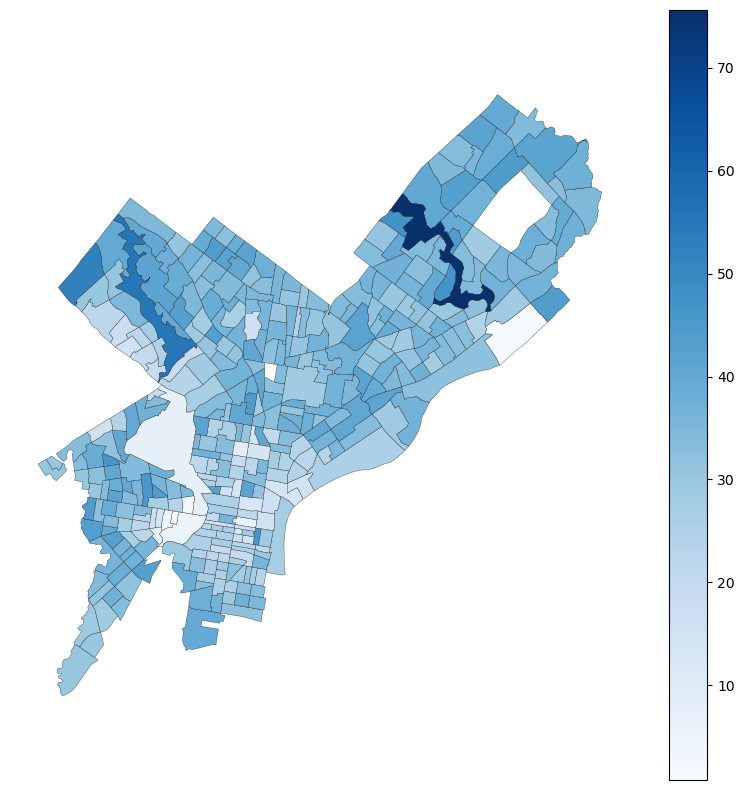

In [197]:
#| label: fig-figure7
#| fig-cap: "Percentage Dependent Population by Census Tract in Philadelphia"
#| code-fold : true
#| code-summary: "Code for Visualization"


# Plot total population by census tract
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
census_data.plot(
    column="Perc_Dependent_Pop",  # Total population column
    cmap="Blues",          # Color map
    legend=True,
    edgecolor="black",
    linewidth=0.2,
    ax=ax
)

ax.axis("off")
plt.show()

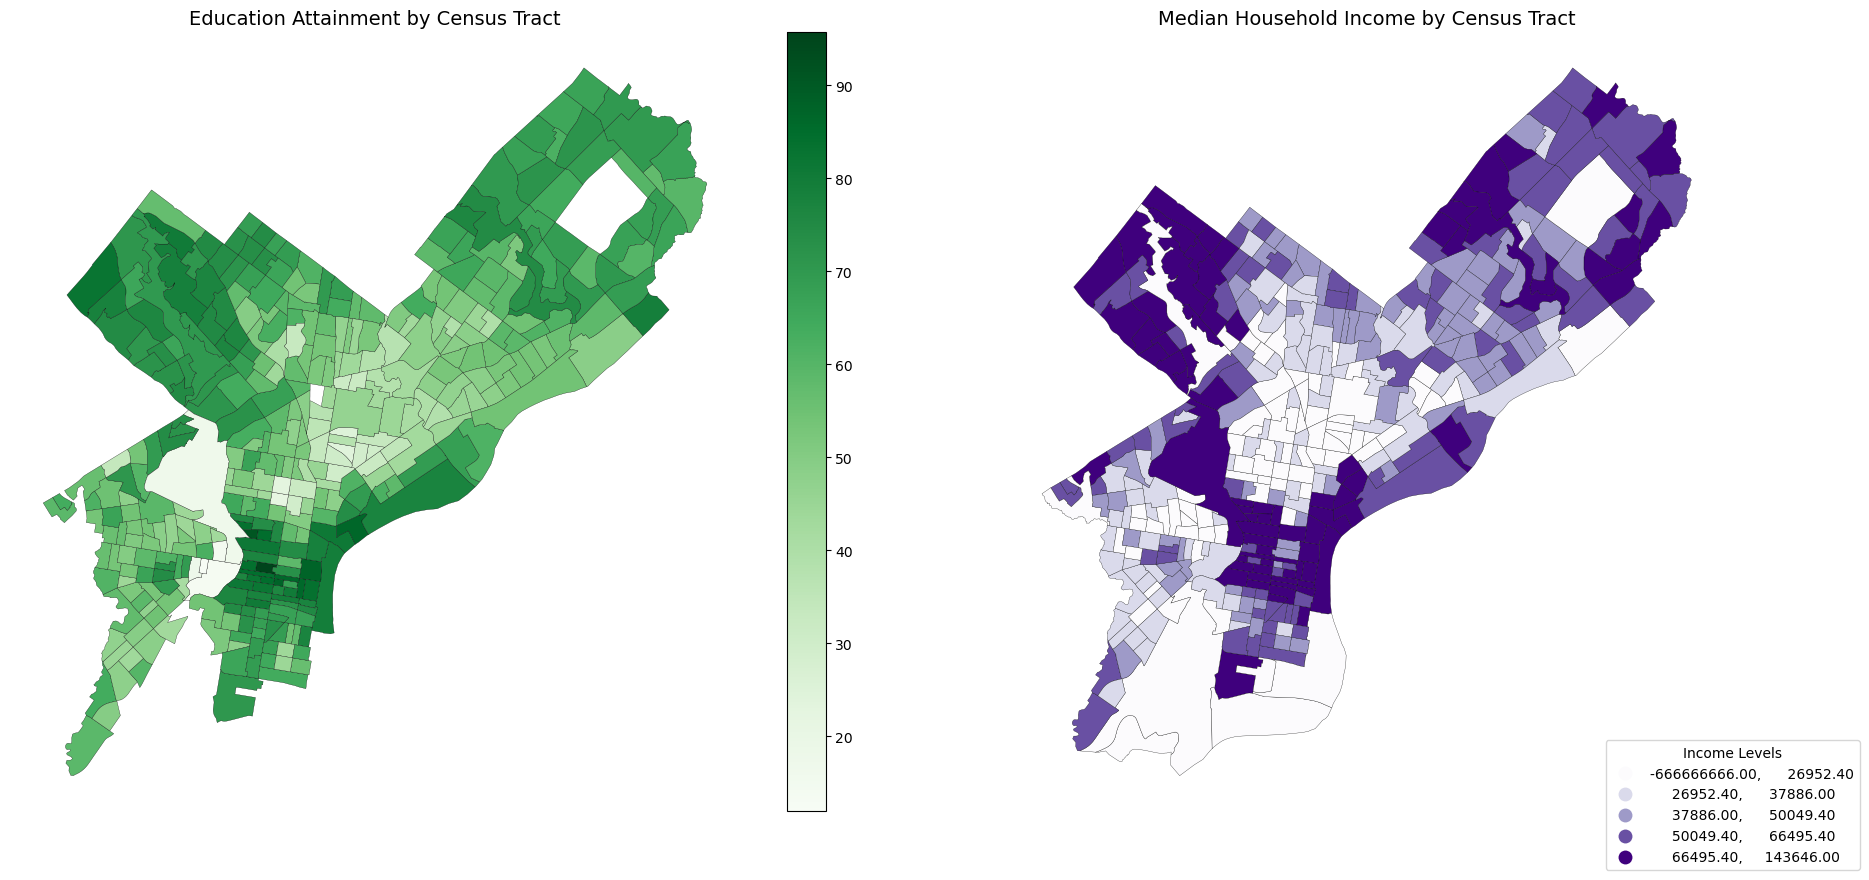

In [198]:
#| label: fig-figur8
#| fig-cap: "Demographic and Population Distribution (2019)"
#| code-fold : true
#| code-summary: "Code for Visualization"

# Plot Education Attainment and Median Household Income
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Education Attainment
census_data.plot(
    ax=axes[0],
    column="Perc_Edu_HS_Higher",
    cmap="Greens",
    edgecolor="black",
    linewidth=0.2,
    legend=True,
)
axes[0].set_title("Education Attainment by Census Tract", fontsize=14)
axes[0].set_axis_off()

# Plot 2: Median Household Income
census_data.plot(
    ax=axes[1],
    column="Median_Household_Income",
    cmap="Purples",
    scheme="quantiles",
    k=5,
    edgecolor="black",
    linewidth=0.2,
    legend=True,
)
axes[1].set_title("Median Household Income by Census Tract", fontsize=14)
axes[1].set_axis_off()

# Customize legend for Median Household Income
income_legend = axes[1].get_legend()
income_legend.set_bbox_to_anchor((1.2, 0.1))  # Adjust position to bottom-right
income_legend.set_title("Income Levels")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()


In [123]:
#| echo: false
#| output: false

%store aggregated_with_canopy_full
%store census_data


Stored 'aggregated_with_canopy_full' (GeoDataFrame)
Stored 'census_data' (GeoDataFrame)


# Summary

Before diving into extensive data processing, an exploratory analysis was conducted to gain a foundational understanding of the datasets and their spatial and statistical characteristics. This step allowed us to identify patterns, outliers, and preliminary relationships between variables, providing valuable context for more in-depth analyses later.

## Spatial Patterns and Trends

Using the cleaned datasets, we created a series of maps to visualize key variables across Philadelphia by census tracts. The visualizations revealed the following:

### Child Blood Lead Levels
- Elevated rates of lead exposure were concentrated in areas around **North Philadelphia** and **Kensington**.

### Asthma and Cancer Prevalence
- **Cancer Prevalence:** Higher concentrations were found in tracts within **northeast** and **northwest Philadelphia**.
- **Asthma Prevalence:** Higher concentrations were observed in areas around **north** and **west Philadelphia**.

### Tree Canopy Coverage
- **Higher Coverage:** Concentrated in **northwest**, **southwest**, and parts of **northeast Philadelphia**.
- **Lower Coverage:** Sparse canopy coverage was observed in **central** and **northern tracts**.

### Heat Vulnerability
- Areas with the highest heat vulnerability scores were concentrated around **north** and **west Philadelphia**, where tree canopy coverage was minimal.

### Non-White Populations
- Census tracts in **north**, **west**, and **southwest Philadelphia** exhibited the highest concentration of non-white populations.

### Educational Attainment
- Higher proportions of adults with at least a high school diploma were concentrated in **northwest**, **south Philadelphia**, and **Center City**.

### Median Household Income
- Areas around **Center City**, **lower north**, and **northeast Philadelphia** had the highest concentration of high median household incomes by census tract.
